# 1) Description and Source of Data

https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz 

This dataset contains 11'759'454 interconnections between 19'354 unique proteins. The data set will be used to create a ‘centrality_score’ for each gene - were 1 is a protein that is a hub gene having multiple interactions with other genes and is considered to be of high risk and 0 is a gene which has no interactions is thus considered of low risk to harm people's life. This file was downloaded using wget from the GNU project.

### 1.1) Mount google drive to colab

In [1]:
# mount google drive to colab
from google.colab import drive
import os
n = 140
drive.mount('/content/drive')
print("#" * n)

# change working directory
print("### colabs default working directory")

print("###\n### path: {}".format(os.getcwd()))
print("#" * n)
print("### setted working directory")

%cd drive/Shareddrives/MADS_Milestone1/

print("###\n### {}".format(os.getcwd()))
print("#" * n)



Mounted at /content/drive
############################################################################################################################################
### colabs default working directory
###
### path: /content
############################################################################################################################################
### setted working directory
/content/drive/Shareddrives/MADS_Milestone1
###
### /content/drive/Shareddrives/MADS_Milestone1
############################################################################################################################################


**Strategy**

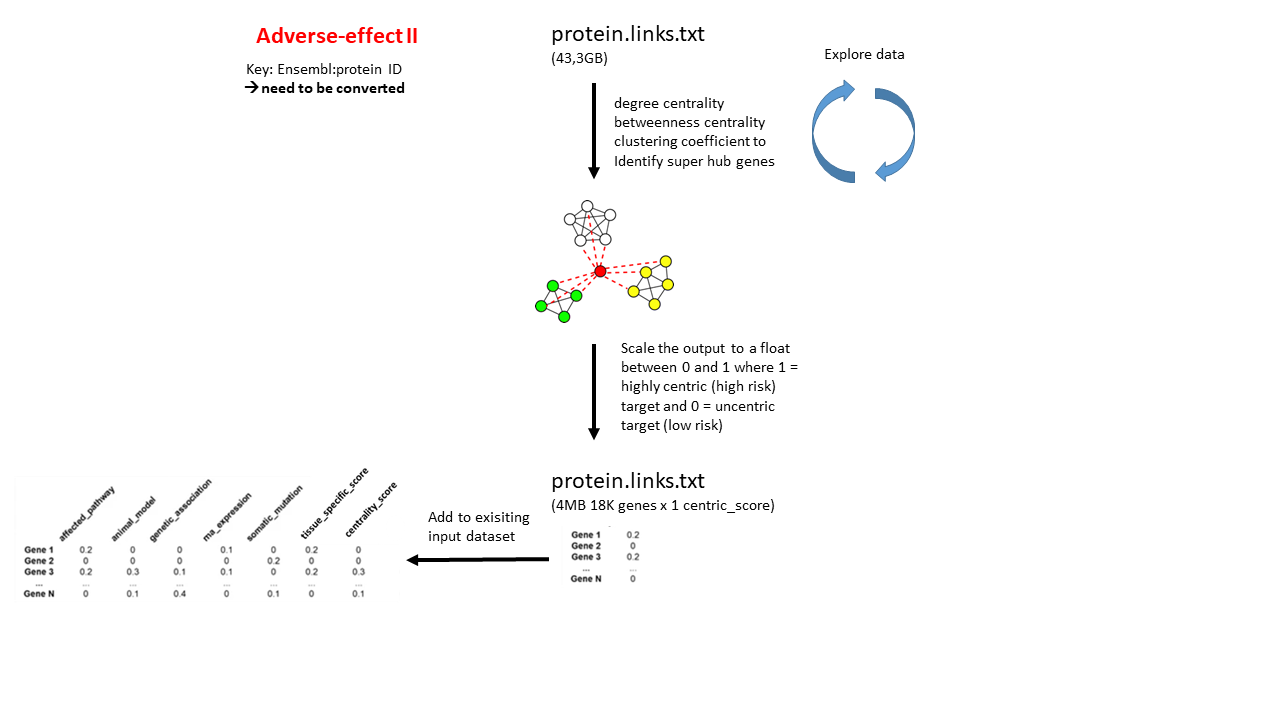

In [ ]:
from IPython.display import Image
Image('Visualizations/centrality.png', width=900, height=500)


### 1.2) Catch all files in directory

In [2]:
import subprocess
import re

# define the ls command to find all results
ls = subprocess.Popen(["ls", "-p", "./Raw_Assets"],
                      stdout=subprocess.PIPE,
                     )

# define the grep command to exclude all folders
grep = subprocess.Popen(["grep", "-v", "/$"],
                        stdin=ls.stdout,
                        stdout=subprocess.PIPE,
                        )

# read from the end of the pipe (stdout)
endOfPipe = grep.stdout

json = {}
txt = {}
csv = {}
gmt = {}
all = []
path = "Raw_Assets/"
# output the files line by line
for line in endOfPipe:  
    
    w = re.sub( "\\\\n'$", "", str(line))
    w = re.sub("^b'", "", w)
    front = re.sub("\d+.", "", w)
    name = re.sub("\..*", "", front)

    all.append(w)
    if ".json" in w:        
        json[name] = path + w
    elif ".txt" in w or ".tsv" in w:
        txt[name] = path + w
    elif ".csv" in w:
        csv[name] = path + w
    else:
        gmt[name] = path + w
    
    
    
#     if (w[0] == "C") | (w[0] == "D"):
#         colnames.append(w)

### 1.3) Download interactome dataset to infer centrality

**Data source: STRING DB:** 

STRING is a database of known and predicted protein-protein interactions. The interactions include direct (physical) and indirect (functional) associations; they stem from computational prediction, from knowledge transfer between organisms, and from interactions aggregated from other (primary) databases.


*Interactions in STRING are derived from five main sources:*
 
- Genomic Context Predictions	
- High-throughput Lab Experiments	
- (Conserved) Co-Expression	
- Automated Text mining	
- Previous Knowledge in Databases

The STRING database currently covers 24'584'628 proteins from 5'090 organisms. We have downloaded only the interactions within humans.

In [ ]:
import os

n = 80
if "protein" not in txt.keys():
  # download STRING interactome of human protein
  print("#"* n)
  print("### Download human protein interactome file to working directory") 
  print("#"* n)
  print("### path: {}".format(os.getcwd()))
  print("#"* n)
  %cd Raw_Assets/
  
  !wget https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz
  
  %cd ../
else: 
  print("#"* n)
  print("### file already exists in working directory")
  print("#"* n)
  print("### path: {}\n### filename: {}".format(os.getcwd(), txt["protein"]))
  
  print("###\n### --> no need to download it again!")
  print("#"* n)
  

################################################################################
### file already exists in working directory
################################################################################
### path: /content/drive/Shareddrives/MADS_Milestone1
### filename: Raw_Assets/9606.protein.links.v11.0.txt.gz
###
### --> no need to download it again!
################################################################################


# 2) Infer Centrality Score to determine potential safety 

### 2.1) import libraires

In [3]:
# importing libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None) # Setting max number of dataframe rows to show
pd.set_option('display.max_columns', None) # Setting max number of dataframe cols to show
import matplotlib.pyplot as plt
import networkx as nx

### 2.2) import dataset

In [4]:
# import network data
df = pd.read_table(txt["protein"], sep=" ") 
# clean ensemblID keep protein IDs
df.protein1.replace("\d*\.","", regex=True, inplace=True)
df.protein2.replace("\d*\.","", regex=True, inplace=True)
df.head()
df.shape

(11759454, 3)

In this dataset are 3 columns.

Each row represents one edge/interaction between two proteins that are evidently interacting physically or functionally. 'protein1' and 'protein2' indicate the according proteins that are interacting. These features are represented as ensembl:protein IDs which need to be converted to gene symbols to JOIN the other datasets. We intially wanted to convert each gene ID to an esembl:gene ID because they are unique and convenient to deal with. However, because it seemed not straight forward to convert the gene symbol in the ground truth dataset to ensembl IDs we have decided to convert everything to gene symbol - to prevent extensive loss of information in the ground truth dataset (in this dataset we do not have so many datapoints and did not want to risk).

The 'combined_score' is a measure of strength/certainty that the interaction exists (the higher the more certain) are computed by combining the probabilities from the different evidence channels, correcting for the probability of randomly observing an interaction. For a more detailed description please see von [Mering, et al Nucleic Acids Res. 2005](https://pubmed.ncbi.nlm.nih.gov/15608232/)

### 2.3) Properties of dataset

In [ ]:
n = 50
print("#"*n)
print("### Column names:\n### {}".format(df.columns.to_list()))
print("#"*n)
print("### Total number of protein interactions:\n### {}M protein interactions".format(round(len(df)/1000000, 1)))
print("###\n### From which there are \n### {} unique proteins".format(len(set(df["protein1"].to_list() + df["protein2"].to_list())))) 
print("#"*n)
print("### Datatypes\n{}".format(df.dtypes)) 
print("#"*n)
print("### Number of missing values:\n{}".format(np.sum(df.apply(lambda x: x.isnull()))))
print("#"*n)


##################################################
### Column names:
### ['protein1', 'protein2', 'combined_score']
##################################################
### Total number of protein interactions:
### 11.8M protein interactions
###
### From which there are 
### 19354 unique proteins
##################################################
### Datatypes
protein1          object
protein2          object
combined_score     int64
dtype: object
##################################################
### Number of missing values:
protein1          0
protein2          0
combined_score    0
dtype: int64
##################################################


define a function that would allow us to convert any gene ID to a gene symbol conveniently. For this task we made use of [*MyGene-API*](https://mygene.info/) a simple Python wrapper for the MyGene-API. *MyGene* providing a simple-to-use REST web services to query/retrieve gene annotation data.

In [ ]:
def convert_any_to_Symbol(ensembl=  ['ENSP00000000233', 'ENSP00000272298', 'ENSP00000253401'], # enter here the gene IDs you want to convert original source ID that needs to be converted with example ensembl:protein IDs
                                   which_ensembl = ['ensembl.protein',  # stateing in which format your entered gene ID are
                                                    'ensembl.gene', 
                                                    'ensembl.transcript',
                                                    'entrezgene'][0], 
                                   species="human"): # which species you want to convert the gene IDs
  
  # check if mygene module is already installed
  import importlib
  exist_mygene = importlib.util.find_spec("mygene")
  
  if exist_mygene is None:
      !pip install mygene
  
  # import mygene module
  import mygene

  # set the connection to the mygene API
  mg = mygene.MyGeneInfo()
  # create the query
  q = mg.querymany(ensembl, scopes=which_ensembl, fields="ensembl,symbol", 
                   species=species, returnall=True)
  
  
  print("#######################################################################################\nmissiging queries")
  print(q["missing"])
  
  print("#######################################################################################\nduplicated queries")

  print(q["dup"])
  
  conv = {}
  n= 0
  for v, i in zip(ensembl, q["out"]):
    #print(n, i)
    #n += 1
    if isinstance(i, list):
      if i != []:    
        if "symbol" in i[0].keys():
          
          conv[v] = i[0]["symbol"]
        else:
          
          conv[v] = "no-symbol"
      else:
        conv[v] = "not-found"
    else: 
      if "symbol" in i.keys():
        conv[v] = i["symbol"]
      else:
        
        conv[v] = "no-symbol"
  print("#######################################################################################\nconverted queries")

  print(conv)
  return conv



check if our convert function is working as expected by checking which proteins have the most interactions 

In [ ]:
# check which proteins have the most interactions
freq = df.protein1.value_counts()
# convert the ensembls to gene symbols
conv = convert_any_to_Symbol(freq.index.to_list(), which_ensembl = "ensembl.protein")


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-19354...done.
Finished.
712 input query terms found no hit:
	['ENSP00000479618', 'ENSP00000349960', 'ENSP00000277541', 'ENSP00000478570', 'ENSP00000350052', 'ENS
#######################################################################################
missiging queries
['ENSP00000479618', 'ENSP00000349960', 'ENSP00000277541', 'ENSP00000478570', 'ENSP00000350052', 'ENSP00000480158', 'ENSP00000268035', 'ENSP00000368699', 'ENSP00000369666', 'ENSP00000402373

we can see that the function is doing what it should do - connect to the *MyGene-API* and fetch the annotations from that database.

Thereby, it failed to match 712 ensembl:protein IDs, There were no duplicated queries in that dataset and converted all other ~19k genes accordingly

There are currently [19'331 protein coding genes](https://www.genenames.org/tools/search/#!/?query=&rows=20&start=0&filter=document_type:gene) with associated official gene symbols. All the rest are non-protein coding genes such as long coding RNA or pseudogenes that do not have a gene symbol but an enemblID which is more granular.

Using the MyGene-API we have noticed that it is not perfect-there are some ensemb:protein ID that were not found to be matched with the database and therefore not convertible - by checking some missing values we found that some had really no matching partner to a gene symbol due to the fact above and some really failed to match up - but were rather in lower number and therefore neglectable

In [ ]:
# convert 4 well known ensembl:protein ID that are well known and one of the top frequent proteins regarding protein interactions manually

conv.update({"ENSP00000479618": "MYC","ENSP00000349960": "ACTB", "ENSP00000277541": "NOTCH1", "ENSP00000478570": "VEGEFA" })

freq = freq.to_frame()
freq["SYMBOL"] = freq.reset_index()["index"].replace(conv).to_list()
freq.rename({"protein1": "Number of connections"}, inplace=True)
freq.head()

,protein1,SYMBOL
ENSP00000229239,7645,GAPDH
ENSP00000451828,6508,AKT1
ENSP00000269305,6196,TP53
ENSP00000380432,6054,INS
ENSP00000479618,5787,MYC


We can see with a quick look that GAPDH is the most interconnected gene by counting the absolute number of edges in that database.

[GAPDH](https://eu.idtdna.com/pages/education/decoded/article/is-gapdh-a-good-reference-sequence) is a very well-known housekeeping gene that is often used as reference to relate expression data because its known to be constantly expressed without strong variation. GAPDH plays an important role in the catalysation of glucose and seems to us not surprisingly one of the highest interconnected protein.



## 2.4) Network analysis to infer centrality scores

In [ ]:
# initiate a network graph
G=nx.from_pandas_edgelist(df, "protein1", "protein2", edge_attr="combined_score")

Our plan was to determine 3 centrality scores which all measure a slightly different angle of the network.

However, as it seemed very challenging (computationally intensive) to compute 2 out of the 3 initially set centrality scores we agreed with Chris Teplovs in one of our calls to focus only on one centrality score which is the 'Degree Centrality' score

### 2.4.1) Degree Centrality
It is a very important metrics that evaluate the importance of a node and is defined as:

$\frac{Number of Neigbors I could have}{Number of Neigbhors I could possibly have}$ 

Examples of nodes with high degree centrality are
1. Twitter: broadcasters — someone who has many followers
2. Disease: Super-spreaders
3. Airport Hubs: for example - Singapore, Frankfurt, New York, or London

In [ ]:
# calculated by
deg_centrality = nx.degree_centrality(G)

In [ ]:
# convert the degree centrality scores into a pandas DataFrame to our convinience 
df_deg_cent = pd.DataFrame([deg_centrality],index=["degree_centrality_score"]).T

# convert all the ensembl:protein IDs to the gene symbols which are also more human readable 
df_deg_cent["SYMBOL"] = df_deg_cent.index.to_series().replace(conv)

# set the gene symbols as index
df_deg_cent.set_index("SYMBOL", inplace=True)

# export the degree_centrality_scores as Intermediate file for the data integration
# df_deg_cent.to_csv("Intermediate_Assets/degree_centrality_score.csv")

df_deg_cent.sort_values(by=["degree_centrality_score"], ascending=False).head()

,degree_centrality_score
SYMBOL,
GAPDH,0.395029
AKT1,0.336279
TP53,0.320157
INS,0.312820
MYC,0.299023


No surprise - we have found the same gene as most interactive as we measured basically the same thing as before - just that we scaled all the different genes according to the total number of nodes.

Export the degree_centrality_scores as Intermediate file as the calculations for the centrality scores below were too computer intensive and not as important in the overall integration therefore not included.

In [ ]:
# export the degree_centrality_scores as Intermediate file for the data integration
centrality.to_csv("Intermediate_Assets/degree_centrality_score.csv")

### 2.4.3) Betweenes Centrality
All shortest paths is a set of shortest paths between all pair of nodes in a given network. Betweenness Centrality of a node is defined as —

$\frac{Number of shortest path through node}{all possible shortest paths}$

This metric captures a different view of the importance of a node. Instead of finding nodes with more number of neighbours, it finds the bottleneck nodes in a network.

And we thought it would nicely identify these genes which are bridging two different pathways and serve as a sensitive bottleneck gene that you don't want to interfere with

In [ ]:
bet_centrality = nx.betweenness_centrality(G)

### 2.4.2) Closeness centrality

computationaly to intensive for colab

In [ ]:
clos_centrality = nx.closeness_centrality(G)

### 2.4.3) Combine the three meassures

computationally to intensive for colab

In [ ]:
centrality = pd.DataFrame([deg_centrality, bet_centrality, clos_centrakity])
centrality.to_csv("Intermediate_Asset/target_centrality_scores")

not relevant for the analysis

In [ ]:
# check frequency of interesting gene such as IL13
freq.where("IL13" == freq.SYMBOL).dropna()

,protein1,SYMBOL
ENSP00000304915,1706.0,IL13


In [ ]:
# fetch all genes that interact with the gene of interest here IL13
IL13 = df.where("ENSP00000304915" == df.protein1).dropna()


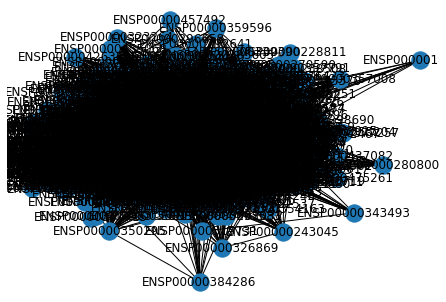

In [ ]:
# generate a subgraph for the gene of interst
H = G.subgraph(["ENSP00000304915"]+ IL13.protein2.to_list())

# Plot the subgraph
nx.draw(H, with_labels=True)
plt.show()